<a href="https://colab.research.google.com/github/bilalzardoa/machine-learning/blob/main/cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import keras
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

val_split = int(0.9 * x_train.shape[0])

x_train, x_val = x_train[:val_split], x_train[val_split:]
y_train, y_val = y_train[:val_split], y_train[val_split:]

In [8]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

((45000, 32, 32, 3), (45000, 1), (10000, 32, 32, 3), (10000, 1))

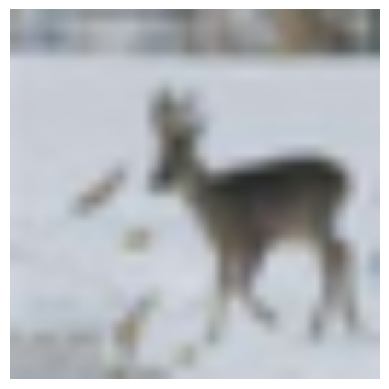

In [9]:
# Plot a single image
img = x_train[20]
# Upscale to 128x128 using bilinear interpolation
img_up = cv2.resize(img, (128,128), interpolation=cv2.INTER_LINEAR)
plt.imshow(img_up)
plt.axis('off')
plt.show()

In [10]:
# normalization_layer = keras.layers.Normalization()
# normalization_layer.adapt(x_train)

# x_train_normalized = normalization_layer(x_train).numpy()
# x_val_normalized = normalization_layer(x_val).numpy()
# x_test_normalized  = normalization_layer(x_test).numpy()

In [44]:
# big convolutions on small feature maps are bad
def get_model():
    model = keras.Sequential()
    model.add(keras.Input(shape=(32, 32, 3)))

    model.add(keras.layers.Rescaling(1./255))
    # First block
    model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.3))

    # Second block
    model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.3))

    # Third block
    model.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.3))

    # Classification head
    model.add(keras.layers.GlobalAveragePooling2D())  # (128,) → averages each 4x4 map to 1 value
    model.add(keras.layers.Dense(128, activation='relu'))  # (128,)
    model.add(keras.layers.Dense(10, activation='softmax'))  # (10,) class probabilities

    return model


In [53]:
model = get_model()

In [54]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,226 (614.16 KB)

 Trainable params: 157,226 (614.16 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
lr = 0.001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

In [56]:
history = model.fit(x_train, y_train, batch_size=128, epochs=100,validation_data=(x_val,y_val),callbacks=[early_stopping], verbose=2)

Epoch 1/100
352/352 - 15s - 41ms/step - accuracy: 0.2897 - loss: 1.8464 - val_accuracy: 0.4024 - val_loss: 1.5942
Epoch 2/100
352/352 - 4s - 11ms/step - accuracy: 0.4500 - loss: 1.4808 - val_accuracy: 0.5046 - val_loss: 1.3579
Epoch 3/100
352/352 - 4s - 12ms/step - accuracy: 0.5263 - loss: 1.2986 - val_accuracy: 0.5726 - val_loss: 1.1943
Epoch 4/100
352/352 - 4s - 11ms/step - accuracy: 0.5716 - loss: 1.1785 - val_accuracy: 0.6018 - val_loss: 1.1086
Epoch 5/100
352/352 - 5s - 15ms/step - accuracy: 0.6016 - loss: 1.1039 - val_accuracy: 0.6488 - val_loss: 1.0060
Epoch 6/100
352/352 - 4s - 12ms/step - accuracy: 0.6260 - loss: 1.0403 - val_accuracy: 0.6554 - val_loss: 0.9662
Epoch 7/100
352/352 - 5s - 14ms/step - accuracy: 0.6413 - loss: 0.9967 - val_accuracy: 0.6906 - val_loss: 0.9072
Epoch 8/100
352/352 - 4s - 11ms/step - accuracy: 0.6574 - loss: 0.9584 - val_accuracy: 0.6832 - val_loss: 0.8881
Epoch 9/100
352/352 - 5s - 14ms/step - accuracy: 0.6724 - loss: 0.9168 - val_accuracy: 0.7110 -

In [57]:
model.evaluate(x_test, y_test,verbose=2)

313/313 - 2s - 5ms/step - accuracy: 0.8010 - loss: 0.5780


[0.5780187249183655, 0.8009999990463257]

In [58]:
def plot_history_smooth(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    plt.figure(figsize=(10,4))
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.figure(figsize=(10,4))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], 'ro-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


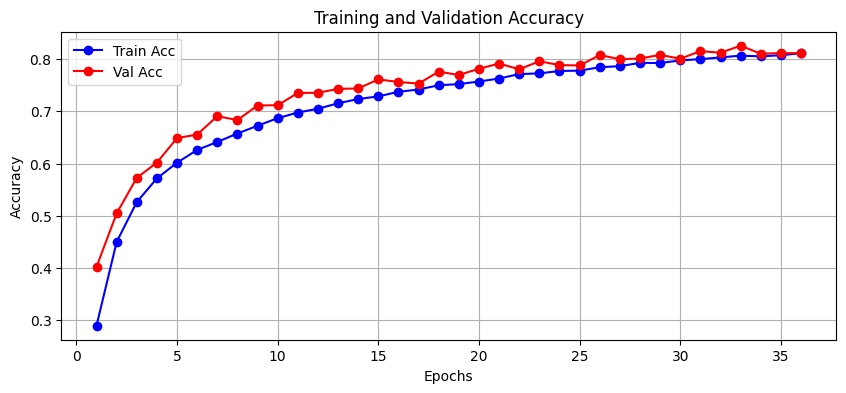

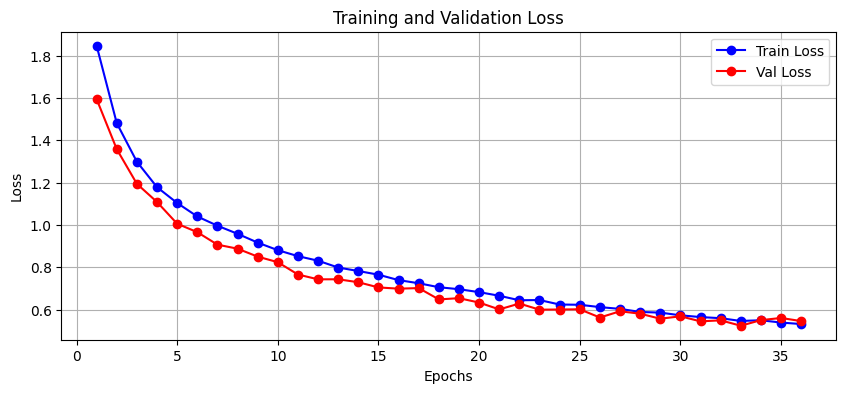

In [59]:
# plot_history(history)
plot_history_smooth(history)

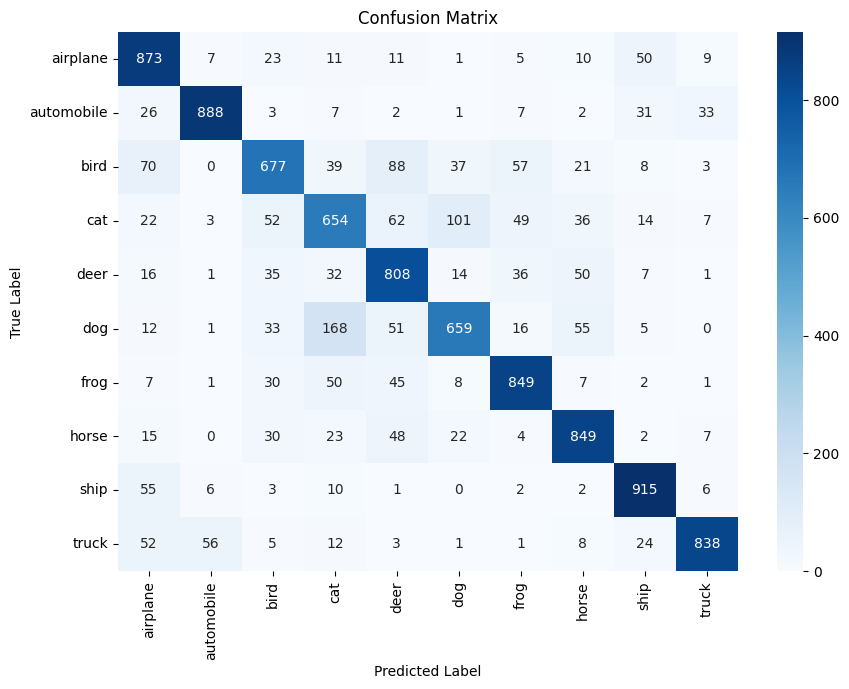

In [60]:
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck'
]

y_preds = model(x_test)
y_preds = np.argmax(y_preds, axis=1)

cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The model has trouble differentiating between similar objects, like dogs and cats or ships and airplanes, most likely due to the small image size (32x32). The solution is either to use a pretrained model and fine-tune it on the dataset, or to add more training data (e.g., through data augmentation or by incorporating more relevant images).